# O melhor modelo para um classificador de planetas

## Autor

Lucas Gabriel Bezerra - 180125770

GitHub: [lucasgbezerra](https://github.com/lucasgbezerra/)

## Objetivo

O objetivo deste artigo é conhecer modelos e treinar um modelo capaz de classificar os planetas conhecidos no sistema solar.

## Motivação

A exploração espacial nos últimos anos tem crescido consideravelmente. Empresas privadas passaram a dedicar seus esforços a algo que era totalmente governamental.

Pensando nisso, um sistema de classificação de planetas pode ser muito útil para sondas e satelites enviadas ao espaço.

## Modelagem

### Instalando depêndencias

- Instalação da biblioteca DuckDuckGo, com o gerenciador de pacotes pip, para realizar a busca pelas imagens utilizadas para o treinamento do modelo e realização de testes.

- Instalação da biblioteca de deep learning fastai.

- Instalação da biblioteca de ML **timm** que é uma coleção de modelos de visão computacional SOTA, camadas, utilitários, otimizadores, agendadores, carregadores de dados, aumentos e também scripts de treinamento/validação com capacidade de reproduzir resultados de treinamento ImageNet.

- Instalação da biblioteca de visualização de dados para Python, **Plotly**

In [2]:
!pip install -Uqq duckduckgo_search fastai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.


In [3]:
!pip install -Uqq timm

In [4]:
!pip install -Uqq plotly

### Baixando imagens

Criação de uma função para buscar imagen a partir do termo passado como paramêtro utilizando a biblioteca do motor de pesquisa DuckDuckGo.

In [5]:
import timm
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *

def search_images(term, max_images=100):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Buscando três imagens para verificar o funcionamento da função e para testes futuros.

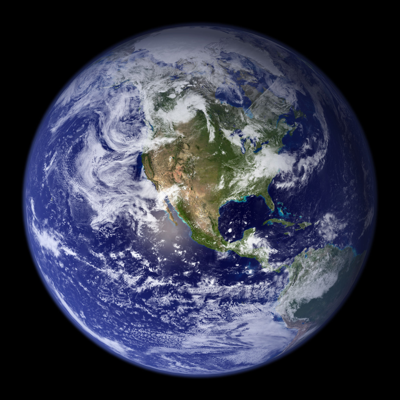

In [6]:
from fastai.vision.all import *
from fastdownload import download_url

urls = search_images('earth', max_images=1)
dest = 'earth.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(400,400)

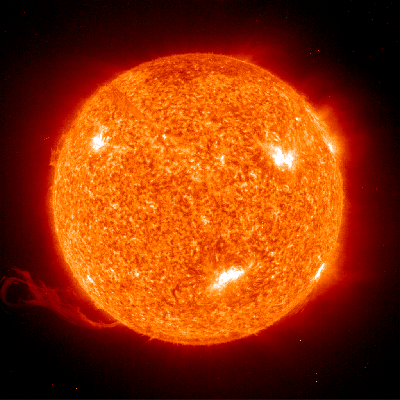

In [7]:
urls = search_images('sun', max_images=1)
dest = 'sun.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(400,400)

Lista de planetas e outros corpos encontrados no espaço que não são planetas que serão utilizadas para pesquisa e como label dos conjuntos de imagens.

In [8]:
planets = [
'Mercury',
'Venus',
'Earth',
'Mars',
'Jupiter',
'Saturn',
'Uranus',
'Neptune',
]

not_planets =['Sun', 'Moon', 'Asteroid', 'Pluto']

Utilizando a função criada para buscar imagens, vamos buscar um conjunto de imagens das diferentes frutas. 

As imagens serão reduzidas e salvas em diretórios, onde cada pasta contem imagens de uma raça, para uso posterior.

In [9]:
path = Path('planets')

from time import sleep

def build_dataset(name_dir, param, searches):
    for o in searches:
        if(name_dir == None):
            directory = o
        else:
            directory = name_dir
        dest = (path/directory)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{param} {o}'))
        sleep(1)
        resize_images(path/directory, max_size=400, dest=path/directory)

        
build_dataset('Not a planet', 'Real photo', not_planets)
build_dataset(None, 'Planet', planets)

Antes de realizar o treinamento do modelo é indicado realizar uma verificação das imagens baixadas, a fim de buscar imagens que possam ter sido baixadas incorretamente e dessa forma possam causar falha no modelo treinado. As imagens baixadas incorretamente serão excluidas.

In [10]:
failed_imgs = verify_images(get_image_files(path))
failed_imgs.map(Path.unlink)
print(f"Número de imagens incorretas: {len(failed_imgs)}")

Número de imagens incorretas: 9


### Formantando conjunto de Imagens

Antes de realizar o treinamento do modelo um bloco de dados será gerado.

O **Datablock** é composto por diversos parâmetros, os parâmetros utilizados nessa modelagem foram:
- *blocks=(ImageBlock, CategoryBlock)*: o tipo de entrada(imagens de cachorro) e saídas (categorias ou raças de cachorros)
- *get_items=get_image_files*: retorna as lista de imagens armazenadas no path
- *splitter=RandomSplitter(valid_pct=0.2, seed=42)*: Divisão do dado entre conjunto de validação e de treinamento, sendo 20% dos dados para validação
- *get_y=parent_label*: o valor y é o nome do 'pai' de cada arquivo, que no caso em questão é a pasta com o a raça dele.
- *item_tfms=[Resize(192, method='squish')]*: reduz o tamanho da imagem antes do treinamento para 192x192 pixels.

In [11]:
db_planets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

### Data augmentation
A fim de melhorar o desempenho do treinamento, e visto a baixa quantidade de dados disponíveis (30 para cada fruta), uma estratégia de transformação das imagens será usada. 

O Data augmentation é a criação de variações aleatórias dos dados de entrada, de tal forma que elas pareção diferentes, apesar de serem a mesma image.

Algumas informações sobre métodos e funções usadas: 
- *aug_transforms* é um padrão de augmentations indicado na aula e com boa performance para imagens de fotos naturais.
- *batch_tfms* é um método do fastai que indica o uso dessas transformações.
- *RandomResizedCrop*: Recorta e redimenciona de maneira aleátoria a imagem

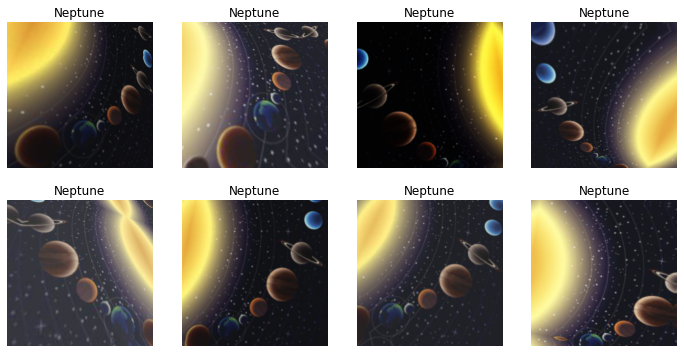

In [12]:
db_planets = db_planets.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms(mult=2))
dls = db_planets.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Treinando o modelo e usando isso para limpar os dados

Criando o *learner* e o fine-tune.

Para treinar o modelo foi utilizado o modelo de visão(*vision model*) **resnet18**.

Além disso o fastai possui o **fine_tune()** que é um método para 'tunar' um modelo, onde ele parte de pesos de uma rede treinada para treinar o modelo desejado.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.562689,0.997347,0.298701,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.087939,0.644084,0.216450,00:08
1,0.871181,0.566289,0.151515,00:08
2,0.695092,0.509935,0.125541,00:08
3,0.601501,0.502915,0.138528,00:08


### Matriz de confusão
A matriz de confusão é uma maneira de ver quais erros estão sendo cometidos pelo modelo, quais as frutas que ele mais confunde.

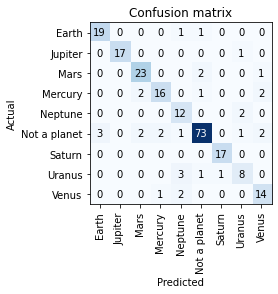

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

As colunas da matriz representam as imagens de frutas que o modelo prediz, e as linhas representam o conjunto de imagens de frutas utilizadas no treinamento.

A diagonal principal representa os acertos (predição condiz com a label). Enquanto as outras intercessões mostram os erros cometidos, sendo quanto maior o número de uma celula mais vezes ocorreu a confusão.

Para entender melhor o que os erros mostram (um erro do modelo ou das imagens) pode ser útil ordenar as imagens pela perda (loss).

**Quanto mais incorreto é o modelo maior a perda (loss)**, especialmente quando o erro ocorre com alta confiança. A perda (loss) também é alta quando a predição está correta porém com pouca confiança na resposta.

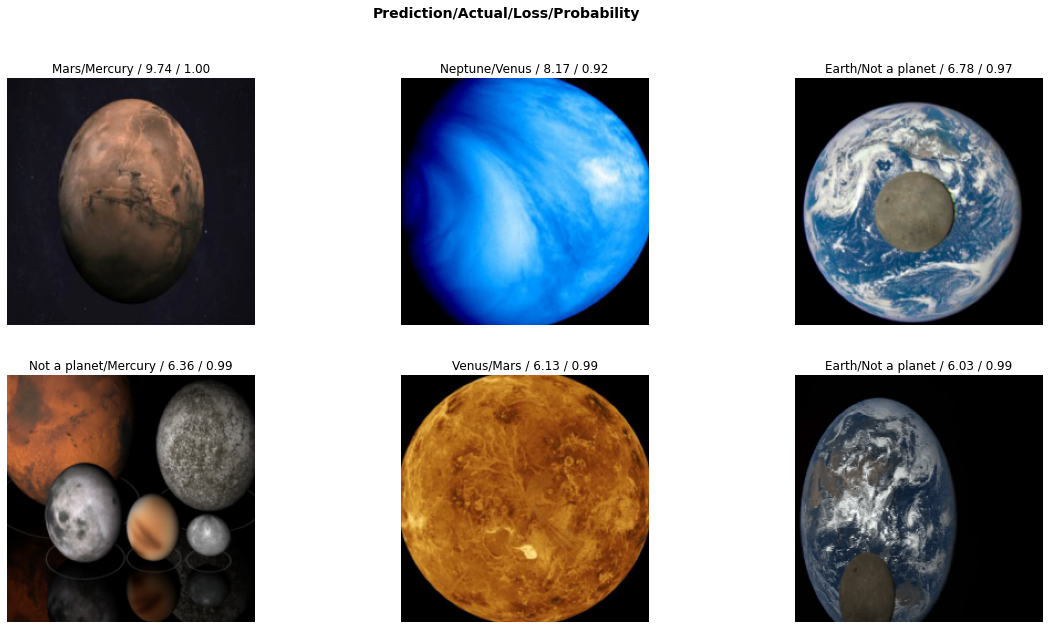

In [15]:
interp.plot_top_losses(6, figsize=(20,10))

Algumas das imagens foram confusões justas devido a semelhança, como é o caso da Blueberry e Grape. Em outros casos a confusão se dá pela imagem baixada ser de outro produto que não o desejado, por exemplo a grapefruit ( que está taxada como grape(uva)

Após esse processo o modelo auxiliou a identificar onde o dado pode ser mais problemático de maneira rápida.

Para melhorar o conjunto de dados é preciso fazer uma **limpeza dos dados**. O fastai possui uma GUI para isso chamada *ImageClassifierCleaner*, essa GUI será usada para selecionar imagens para remoção ou realocar.

In [16]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

Para realizar as remoções e realocamento das imagens indicadas basta utilizar esses 2 loops:

In [17]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Uma vez que ocorre a limpeza dos dados, o modelo pode ser **re-treinado** e alcançar melhores resultados.

In [18]:
dls = db_planets.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)

### learning rate vs loss

Uma dúvida que sempre fica quando se vai treinar um modelo é: quantas épócas são necessárias?
Tentanto entender isso, encontrei a learning rate Finder *lr_find* que plota um **gráfico da relação learning rate vs loss de um learner**. Isso auxiliou bastante na redução do "chute" do que seria uma boa taxa de aprendizado

SuggestedLRs(valley=0.0006918309954926372)

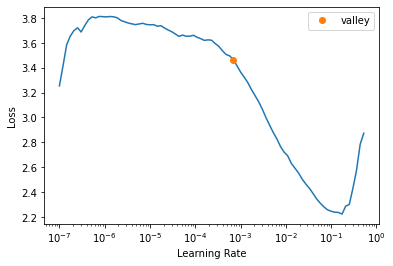

In [19]:
learn.lr_find()

O Gráfico indica que um bom número de épocas seriam 3

In [20]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.739044,0.716481,0.221739,00:09


epoch,train_loss,valid_loss,error_rate,time
0,1.198645,0.494512,0.152174,00:09
1,0.962141,0.402297,0.121739,00:09
2,0.786411,0.349027,0.104348,00:09


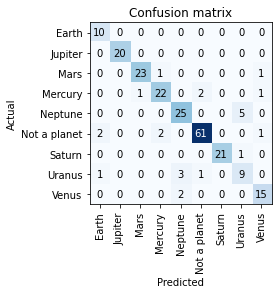

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Buscando o melhor modelo

Depois de ter os dados limpos e treinar novamente o modelo, o resultado obtido pelo resnet18 foi de 9% de taxa de erro, 39% de perda de validação e 22% de perda de treinamento, demorando cerca de 30 segundos em cada época.

Com isso em mente resolvi buscar novos modelos, que possam trazer resultados melhores. 
Para ter uma base do que seria um bom modelo, resolvi buscar estatisticas já existentes de modelos conhecidos. O GitHub do [Pytorch Image Models (timm)](https://github.com/rwightman/pytorch-image-models#introduction) foi a referência utilizada

In [22]:
import pandas as pd

url = 'https://raw.githubusercontent.com/rwightman/pytorch-image-models/main/results/results-imagenet.csv'
df_results = pd.read_csv(url)

In [23]:
df_results.head()

,model,top1,top1_err,top5,top5_err,param_count,img_size,crop_pct,interpolation
0,beit_large_patch16_512,88.602,11.398,98.656,1.344,305.67,512,1.000,bicubic
1,beit_large_patch16_384,88.406,11.594,98.606,1.394,305.00,384,1.000,bicubic
2,tf_efficientnet_l2_ns,88.350,11.650,98.650,1.350,480.31,800,0.960,bicubic
3,tf_efficientnet_l2_ns_475,88.232,11.768,98.546,1.454,480.31,475,0.936,bicubic
4,deit3_large_patch16_384_in21ft1k,87.716,12.284,98.512,1.488,304.76,384,1.000,bicubic


A fim de agrupar as arquiteturas a partir de suas similaridades, será adicionada a tabela a coluna family

In [24]:
url_infer = 'https://raw.githubusercontent.com/rwightman/pytorch-image-models/main/results/benchmark-infer-amp-nhwc-pt111-cu113-rtx3090.csv'

def get_data(col):
    df = pd.read_csv(url_infer).merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg|swin')]

df = get_data('infer_samples_per_sec')


In [25]:
import plotly.express as px

px.scatter(df, width=1000, height=800, size=df['infer_img_size']**2, title='Inferencia',x='secs',  y='top1', log_x=True, color='family', hover_name='model', hover_data=['infer_img_size'])

![](https://i.imgur.com/EMu7G1j.png)

### Explicando o gráfico

O gráfico tem no eixo x o tempo, em segundos, gasto para processar uma imagem. No eixo y do gráfico é representado a precisão no ImageNet. A bolas presentes no gráfico que representam cada modelo possuem cores semelhantes as suas "famílias" de arquitetura, enquanto o tamanho das bolinhas representam a proporção do tamanho das imagens usadas.

### Analíse do gráfico

O Gráfico mostra que os modelos da "família" levit são os que tem a maior precisão com menores velocidades.

Outro "família" que se destaca mas pela acurácia é a beit, ela tem os melhores indíces de acurácia porem os piores de tempo.

Por último,  os modelos da "família" ConvNeXt, que estão próximos ao meio do gráfico.

O modelo usado para treinamento, antes de realizar uma limpeza dos dados, foi o resnet18 da familia resnet que vários modelos espalhados, indo desde um dos mais rápidos até outros com mais precisão.



## Escolhendo 3 modelos

Com o mesmo conjunto de dados, será feito 3 treinamentos 1 com cada modelo (Resnet50 , levit_256, convnext_tiny)

### Resnet50

In [27]:
learn_resnet = vision_learner(dls, resnet50, metrics=error_rate)
learn_resnet.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.081949,0.599765,0.169565,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.790704,0.563984,0.108696,00:12
1,0.655350,0.515178,0.100000,00:12
2,0.541283,0.493375,0.100000,00:13


### levit_256

SuggestedLRs(valley=0.0014454397605732083)

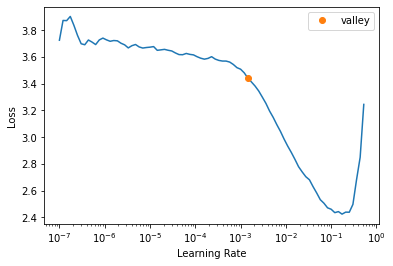

In [29]:
learn_levit = vision_learner(dls, 'levit_256', metrics=error_rate)
learn_levit.lr_find()

In [30]:
learn_levit.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,3.213107,1.438111,0.491304,00:09


epoch,train_loss,valid_loss,error_rate,time
0,2.011974,1.079557,0.373913,00:09
1,1.703470,0.751594,0.252174,00:10
2,1.539419,0.717223,0.234783,00:09


### Convnext_tiny

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


SuggestedLRs(valley=0.0006918309954926372)

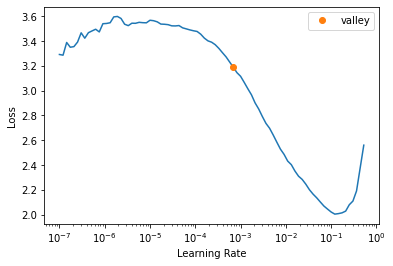

In [31]:
learn_conv = vision_learner(dls, 'convnext_tiny', metrics=error_rate)
learn_conv.lr_find()

In [32]:
learn_conv.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.424916,0.817548,0.265217,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.102212,0.577926,0.165217,00:41
1,0.917480,0.453671,0.134783,00:41
2,0.809756,0.411195,0.134783,00:41


Com base no treinamento dos dois modelos, percebeu-se que o resnet50 obteve a melhor taxa de erro, e uma valid_loss proxima do convnext_tiny, dessa forma, ele será o utiliado para deploy

## Passo 4 - Testando o modelo (resnet50)

Para utilizar o modelo basta usar a linha de código a seguir com uma imagem do cachorro. Será retornada a raça do cachorro e a probabilidade de correspondência obtida.

```python

data_type,_, probs = learn.predict(PILImage.create('imagem.jpg'))
```

In [37]:
planet ,_, probs = learn_resnet.predict(PILImage.create('earth.jpg'))

print(f'Probabilidade de ser {planet} é de {probs.sort()[0][-1]*100:.2f}%')

Probabilidade de ser Earth é de 99.99%


In [38]:
planet ,_, probs = learn_resnet.predict(PILImage.create('sun.jpg'))

print(f'Probabilidade de ser {planet} é de {probs.sort()[0][-1]*100:.2f}%')

Probabilidade de ser Not a planet é de 99.99%


## Deploy do modelo

### Exportar o modelo

O primeiro passo para realizar o deploy do modelo é necessário exportá-lo, para isso será usado o método export() do learner

In [39]:
learn_resnet.path = Path('.')
learn_resnet.export()

### Deploy no huggin Face

Seguindo os passos descritos no hugging face. Um space foi criado, clonado e o arquivo app.py foi criado.

O arquivo **app.py** foi preenchido com o script:

```python
import gradio as gr
from fastai.vision.all import *

learn = load_learner('export.pkl')
labels = learn.dls.vocab

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "Planets Classifier"
examples = ['./imgs/mars.jpg', './imgs/earth.jpg', './imgs/sun.jpg',  './imgs/pluto.jpg']

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.inputs.Image(shape=(512, 512)),
    outputs=gr.outputs.Label(num_top_classes=3),
    title=title,
    examples=examples,
    )
iface.launch(inline=False)
```

O repositório com o **deploy** pode ser acessado no [huggingFace](https://huggingface.co/spaces/lucasgbezerra/planets_classifier)

[![](https://i.imgur.com/UQ5S97S.png)](https://huggingface.co/spaces/lucasgbezerra/planets_classifier)

## Conclusão

As diferentes arquiteturas e seus modelos tem diferentes performances e sua utilização esta totalmente ligada a tal. Percebi que Alguns modelos como os da "família" levit são voltados acima de tudo para a velocidade, isso implica que sua acurácia não é tão boa como alguns da "família" resnet por exemplo, então escolher um modelo depende muito do contexto ao qual a aplicação está inserido e o que é esperado dele.

Outro ponto importante é que mesmo com o uso de modelos mais precisos, a taxa de erro ainda não diminuiu drasticamente o que indica que a quantidade e a qualidade de dados disponíveis pra treinamento, deve ser melhorada nesse caso.
